In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, Lasso, Ridge, RidgeClassifier, SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support, f1_score, r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint, gamma as sp_gamma, expon as sp_expon, uniform as sp_uniform
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import cPickle as pickle

In [2]:
df_features = pd.read_csv('../data/modeling/SPORTS/feature_data_SPORTS_21205.csv', sep='|')
df_targets = pd.read_csv('../data/modeling/SPORTS/target_data_SPORTS_21205.csv', sep='|')

df_features = df_features.set_index('owner').set_index("id", append=True)

df_targets = df_targets.set_index('owner').set_index("id", append=True)

df_targets = df_targets.drop('image_tags', axis=1)

target_columns = list(df_targets.columns)
target_columns.remove('image_ntags')
target_columns

df = df_features.join(df_targets, how='inner')

df.dropna(axis=0, inplace=True)

In [3]:
def name_quantile(x, limits):
    quantile_cats = range(1, len(limits)+1, 1)
    for cat, limit in zip(quantile_cats, limits):
        if x <= limit:
            return cat

def create_quantile_target_col(df_train, df_test, target_columns, col_name, n_quantiles=5):
    """
    Create a new column in both DataFrames that bins a target column into categories.
    
    PARAMETERS
    ----------
    df_train : pandas.DataFrame
        The training set data.
        
    df_test : pandas.DataFrame
        The testint set data.
    
    n_quantiles : int
        The number of bins. For 4 bins (0 to 0.25, 0.25 to 0.5, etc...), n_quantiles=4.
        
    col_name : str
    
    target_columns : list
    
    RETURNS
    -------
    df : DataFrame
    
    target_columns : list        
    """
    min_value = df_train[col_name].min()
    max_value = df_train[col_name].max()
    limits = []
    for i in range(1, n_quantiles+1):
        limits.append(df_train[col_name].quantile(i/float(n_quantiles)))
    
    new_col_name = col_name+"_quantile"
    target_columns.append(new_col_name)
    
    df_train.loc[:, new_col_name] = df_train[col_name].apply(lambda x: name_quantile(x, limits))
    df_test.loc[:, new_col_name] = df_test[col_name].apply(lambda x: name_quantile(x, limits))
    return df_train, df_test, target_columns

def pop_columns(df, col_names):
    for i, name in enumerate(list(col_names)):
        if i == 0:
            df_dropped_cols = df.pop(name)
        else:
            df_dropped_cols = pd.concat((df_dropped_cols, df.pop(name)), axis=1)
    return df, df_dropped_cols

In [4]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

In [5]:
df_train, df_test, target_columns = create_quantile_target_col(df_train, df_test, target_columns, 'image_views', 4)
df_train, df_test, target_columns = create_quantile_target_col(df_train, df_test, target_columns, 'image_ncomments', 4)
df_train, df_test, target_columns = create_quantile_target_col(df_train, df_test, target_columns, 'image_nfavs', 4)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
X_train, y_train = pop_columns(df_train, target_columns)
X_test, y_test = pop_columns(df_test, target_columns)

In [7]:
X_columns = X_train.columns
y_columns = y_train.columns

In [8]:
scaler_mean_std = StandardScaler()
X_train = scaler_mean_std.fit_transform(X_train)
X_test = scaler_mean_std.transform(X_test)

In [9]:
X_train = pd.DataFrame(data=X_train, columns=X_columns)
X_test = pd.DataFrame(data=X_test, columns=X_columns)

In [10]:
y_train.head(1)

,,user_is_pro,user_can_buy_pro,user_total_views,image_ncomments,image_nfavs,image_nsets,image_npools,image_views,image_views_quantile,image_ncomments_quantile,image_nfavs_quantile
owner,id,,,,,,,,,,,
12385792@N00,11378305226,1,0,7760,0,0,1,0,6,1,1,1


### GRID SEARCH - Image Views Quantile (IVQ)

#### Set Search Parameters

In [27]:
param_distributions = {'Logistic': {"C": sp_expon(loc=0.001, scale=1),
                                    "fit_intercept": [True, False],
                                    "intercept_scaling": sp_randint(1, 5),
                                    "warm_start": [False, True]
                                    },
                       'RandomForest': {"max_depth": None,
                                        "max_features": ['auto', None],
                                        "min_samples_split": sp_randint(1, 201),
                                        "min_samples_leaf": sp_randint(1, 201),
                                        "criterion": ["gini", "entropy"],
                                        "oob_score": True,
                                        "warm_start": [False, True] 
                                        },
                       'AdaBoost_DT': {"learning_rate": sp_expon(loc=0.001, scale=1.5),
                                       "algorithm" : ['SAMME.R', 'SAMME']
                                       },
                       'GBC': {"learning_rate": sp_expon(loc=0.001, scale=0.5),
                               "subsample": sp_uniform(loc=0.2, scale=0.8),
                               "max_features": [None, 'auto'],
                               "warm_start": [True, False],
                               "max_depth": [3, 4, 5],
                               },
                       'SVC': {"C": sp_expon(loc=0.001, scale=2),
                               "kernel": ['rbf', 'poly'],
                               "degree": sp_randint(2, 10),
                               "coef0": [0, 1, 2],
                               "shrinking": [True, False]
                               }
                       }

#### Build Models (IVQ)

In [29]:
DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=10, min_samples_leaf=10,
      min_weight_fraction_leaf=0.0, max_features=300, random_state=30, max_leaf_nodes=20, class_weight=None,
      presort=False)

model_ivq_LogitClassifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                               class_weight=None, random_state=25,
                                               solver='liblinear', max_iter=1000, multi_class='ovr', verbose=2,
                                               n_jobs=36)

model_ivq_RandomForest = RandomForestClassifier(n_estimators=1000, min_weight_fraction_leaf=0.0, n_jobs=36,
                                                random_state=42, verbose=2, class_weight=None, bootstrap=True)

model_ivq_AdaBoost_DT = AdaBoostClassifier(base_estimator=DT, n_estimators=300, random_state=12)

model_ivq_GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0,
                                           random_state=21, verbose=0,
                                           max_leaf_nodes=12, presort='auto')

model_ivq_SVC = SVC(gamma='auto', probability=True,
                    tol=0.001, cache_size=1000, class_weight=None, verbose=True, max_iter=-1,
                    decision_function_shape='ovr', random_state=1)


#### Logistic Random Search CV

In [ ]:
n_iter_search = 30
random_search_LogitClassifier = RandomizedSearchCV(estimator=model_ivq_LogitClassifier,
                                                   param_distributions=param_distributions['Logistic'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_LogitClassifier.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_LogitClassifier.grid_scores_

In [ ]:
random_search_LogitClassifier.best_score_

In [ ]:
best_LogitClassifier = random_search_LogitClassifier.best_estimator_
y_pred = best_LogitClassifier.predict(X_test)
print "Best Logit Classifier F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### Random Forest Random Search CV

In [ ]:
n_iter_search = 30
random_search_RandomForest = RandomizedSearchCV(estimator=model_ivq_RandomForest,
                                                   param_distributions=param_distributions['RandomForest'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_RandomForest.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_RandomForest.best_score_

In [ ]:
best_RandomForest = random_search_RandomForest.best_estimator_
y_pred = best_RandomForest.predict(X_test)
print "Best Random Forest Classifier F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### AdaBoost DT Random Search CV

In [ ]:
n_iter_search = 30
random_search_AdaBoost_DT = RandomizedSearchCV(estimator=model_ivq_AdaBoost_DT,
                                                   param_distributions=param_distributions['AdaBoost_DT'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_AdaBoost_DT.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_AdaBoost_DT.best_score_

In [ ]:
best_AdaBoost_DT = random_search_AdaBoost_DT.best_estimator_
y_pred = best_AdaBoost_DT.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### Gradient Boost Classifier Random Search CV

In [30]:
n_iter_search = 40
random_search_GBC = RandomizedSearchCV(estimator=model_ivq_GBC,
                                       param_distributions=param_distributions['GBC'],
                                       n_iter=n_iter_search,
                                       n_jobs=36, cv=5, verbose=1, random_state=30, error_score='raise')
random_search_GBC.fit(X_train, y_train['image_views_quantile'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed: 67.9min
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed: 95.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=12,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=21, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=40, n_jobs=36,
          param_distributions={'max_features': [None, 'auto'], 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9cf850c6d0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9cf851b850>, 'warm_start': [True, False], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=30, refit=True,
          scoring=None, verbose=1)

In [31]:
random_search_GBC.best_score_

0.73614713510964391

In [32]:
best_GBC = random_search_GBC.best_estimator_
y_pred = best_GBC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

Best AdaBoost DT F1 Score:  0.745162994441


In [43]:
new_params = best_GBC.get_params()
new_params['n_estimators'] = 1000
new_params['verbose'] = 2

In [44]:
new_model_ivq_GBC = GradientBoostingClassifier(**new_params)

In [45]:
new_model_ivq_GBC.fit(X_train, y_train['image_views_quantile'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       17394.7394         428.4469          202.13m
         2       15607.2196         226.9874          200.65m
         3       14446.7362         150.6848          198.27m
         4       13650.8799          92.1420          199.15m
         5       13094.3819          61.0891          200.64m
         6       12598.4263          49.5992          200.76m
         7       12259.9390          38.7950          201.24m
         8       11946.5230          31.4153          199.45m
         9       11697.0205          21.0329          197.50m
        10       11451.6005          20.4354          196.28m
        11       11239.4997           9.9764          195.64m
        12       11049.8318          12.8838          195.18m
        13       10847.9050          17.0746          194.48m
        14       10662.2817           9.7841          192.52m
        15       10520.7765          11.0092          192.04m
       

GradientBoostingClassifier(init=None, learning_rate=0.265159939001,
              loss='deviance', max_depth=5, max_features=None,
              max_leaf_nodes=12, min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=21, subsample=0.884928788086,
              verbose=2, warm_start=False)

In [49]:
new_model_ivq_GBC.get_params()

{'init': None,
 'learning_rate': 0.2651599390014479,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'presort': 'auto',
 'random_state': 21,
 'subsample': 0.8849287880855492,
 'verbose': 2,
 'warm_start': False}

In [50]:
f1_scores = []
num_estimators = new_model_ivq_GBC.get_params()['n_estimators']

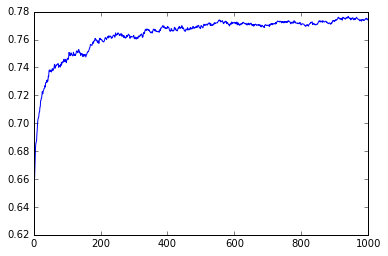

In [51]:
for i, y_pred in zip(range(1, num_estimators+1), new_model_ivq_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='weighted', sample_weight=None))

plt.plot(f1_scores, 'b')

In [53]:
with open('../models/model_GBC_IVQ_1000.pkl', 'w') as f:
    pickle.dump(new_model_ivq_GBC, f)

#### SVC Random Search CV

In [ ]:
n_iter_search = 30
random_search_SVC = RandomizedSearchCV(estimator=model_ivq_SVC,
                                                   param_distributions=param_distributions['SVC'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_SVC.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_SVC.best_score_

In [ ]:
best_SVC = random_search_SVC.best_estimator_
y_pred = best_SVC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

### GRID SEARCH - Image nComments Quantile (ICQ)

In [55]:
param_distributions = {'Logistic': {"C": sp_expon(loc=0.001, scale=1),
                                    "fit_intercept": [True, False],
                                    "intercept_scaling": sp_randint(1, 5),
                                    "warm_start": [False, True]
                                    },
                       'RandomForest': {"max_depth": None,
                                        "max_features": ['auto', None],
                                        "min_samples_split": sp_randint(1, 201),
                                        "min_samples_leaf": sp_randint(1, 201),
                                        "criterion": ["gini", "entropy"],
                                        "oob_score": True,
                                        "warm_start": [False, True] 
                                        },
                       'AdaBoost_DT': {"learning_rate": sp_expon(loc=0.001, scale=1.5),
                                       "algorithm" : ['SAMME.R', 'SAMME']
                                       },
                       'GBC': {"learning_rate": sp_expon(loc=0.001, scale=0.5),
                               "subsample": sp_uniform(loc=0.2, scale=0.8),
                               "max_features": [None, 'auto'],
                               "warm_start": [True, False],
                               "max_depth": [3, 4, 5],
                               },
                       'SVC': {"C": sp_expon(loc=0.001, scale=2),
                               "kernel": ['rbf', 'poly'],
                               "degree": sp_randint(2, 10),
                               "coef0": [0, 1, 2],
                               "shrinking": [True, False]
                               }
                       }

#### Build Models (ICQ)

In [56]:
DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=10, min_samples_leaf=10,
      min_weight_fraction_leaf=0.0, max_features=300, random_state=30, max_leaf_nodes=20, class_weight=None,
      presort=False)

model_icq_LogitClassifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                               class_weight=None, random_state=25,
                                               solver='liblinear', max_iter=1000, multi_class='ovr', verbose=2,
                                               n_jobs=36)

model_icq_RandomForest = RandomForestClassifier(n_estimators=1000, min_weight_fraction_leaf=0.0, n_jobs=36,
                                                random_state=42, verbose=2, class_weight=None, bootstrap=True)

model_icq_AdaBoost_DT = AdaBoostClassifier(base_estimator=DT, n_estimators=300, random_state=12)

model_icq_GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0,
                                           random_state=21, verbose=0,
                                           max_leaf_nodes=12, presort='auto')

model_icq_SVC = SVC(gamma='auto', probability=True,
                    tol=0.001, cache_size=1000, class_weight=None, verbose=True, max_iter=-1,
                    decision_function_shape='ovr', random_state=1)


#### GB Classifier Random Search

In [ ]:
n_iter_search = 20
random_search_GBC = RandomizedSearchCV(estimator=model_icq_GBC,
                                       param_distributions=param_distributions['GBC'],
                                       n_iter=n_iter_search,
                                       n_jobs=36, cv=3, verbose=1, random_state=30, error_score='raise')
random_search_GBC.fit(X_train, y_train['image_ncomments_quantile'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
random_search_GBC.best_score_

In [ ]:
best_GBC = random_search_GBC.best_estimator_
y_pred = best_GBC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_ncomments_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

In [ ]:
new_params = best_GBC.get_params()
new_params['n_estimators'] = 1000
new_params['verbose'] = 2

In [ ]:
new_model_icq_GBC = GradientBoostingClassifier(**new_params)
new_model_icq_GBC.fit(X_train, y_train['image_ncomments_quantile'])

In [ ]:
new_model_icq_GBC.get_params()

In [ ]:
f1_scores = []
num_estimators = new_model_icq_GBC.get_params()['n_estimators']
for i, y_pred in zip(range(1, num_estimators+1), new_model_icq_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_ncomments_quantile'], y_pred, labels=None, pos_label=None, average='weighted', sample_weight=None))

plt.plot(f1_scores, 'b')

### GRID SEARCH - Image nFavs Quantile (InFQ)

In [ ]:
rv = sp_expon(loc=0.001, scale=1.5)

In [ ]:
plt.hist(rv.rvs(1000), bins=40)
plt.plot()

In [ ]:
nums = rv.rvs(1000)